# Implementation and evaluation of region growing

Data Analysis MoBi SS2021, Topic 04: Biomedical image analysis

Tutor: Nicolas Peschke

Group 04: Marie Becker, Ina Jung, Laura Kaschnitz, Johanna Möller

<br>

# Abstract

Region growing is an interesting approach for image segmentation which can be used to evaluate microscopy images and
to detect cellular structures like nuclei.
In this project, algorithms for seeded and unseeded region growing are implemented. These methods are used to form
regions, by assigning all pixels in the image. The major difference of the two algorithm is the start: while seeded
region growing starts form initially calculated seeds, unseeded region growing starts from a randomly chosen start
pixel. After regions are detected, they are merged to prevent oversegmentation.


Here, the implemented algorithms were executed on the datasets N2DH-GOWT1, N2DL-HeLa and NIH3T3.
In order to reduce noise, preprocessing was performed on the images. To further improve results, the parameters
used during region growing were adjusted for each data set. To evaluate the segmented image, the Dice score was used.
For this, the obtained result images were compared to manually segmented ground truth images.


Both seeded and unseeded region growing algorithms led to good results with high Dice scores up to 0.95 for plain
images. A disadvantage of the implementation is, that large computing power is required because each pixel is
assigned individually. However, vectorization led to an acceptable speed.
An improvement of the algorithm would be the simultaneous allocation of more than one pixel.
This could result in equally good Dice scores and faster runtime.
A further issue are interfering image elements with intensities similar to
nuclei and this is still a challenge to be overcome.
Another future improvement would be an automatic parameter determination for the different parameters used in
preprocessing, seed detection and region merging. In this project, all parameters were determined manually.


# Table of contents
1.	Introduction
1.	Datasets – N2DH-GOWT1, N2DL-HeLa and NIH3T3
1.	Imports
1.	Preprocessing <br>
    1. Clipping <br>
    1. Filtering <br>
1.	Segmentation algorithm <br>
    1. Seeded region growing algorithm <br>
        1. Seed selection <br>
            1. Seed selection based on similarities <br>
            1. Seed selection based on Euclidean distance <br>
        1. Seeded region growing <br>
    1. Unseeded region growing algorithm <br>
    1. Region merging <br>
        1. Region merging based on similarity of intensity <br>
        1. Region merging based on size <br>
1. Differences between seeded and unseeded region growing <br>
1.	Evaluation measures <br>
    1. Dice score <br>
1. Results <br>
    1. N2DH-GOWT1 <br>
    1. N2DL-HeLa <br>
        1. Shifted intensity range in N2DL-HeLa <br>
        1. High cell density and intensity differences of nuclei <br>
        1. Final results <br>
    1. NIH3T3 <br>
        1. Bright spots in NIH3T3 data set <br>
        1. Blurs in NIH3T3 data set <br>
        1. Changing background intensities <br>
        1. Final results <br>
    1. Evaluation of preprocessing <br>
    1. Comparison seeded and unseeded region growing results <br>
1. Challenges <br>
    1. Optimizing seeded region growing algorithm <br>
    1. Optimizing unseeded region growing algorithm <br>
    1. Comparison seeded and unseeded region growing algorithms <br>
    1. Memory error <br>
1. Discussion
1. Bibliography

<br>

# Introduction

Image segmentation is an image processing method in the field of data analysis, which role has become increasingly
important in recent years.
It consists of grouping pixels of an image by similarity of image intensities and thus creating regions of pixels
that can be used for data analysis and evaluation.
In this way, image content can be simplified, and its representation can be modified by using methods like
thresholding, boundary or region-based segmentation or hybrid techniques.
Image segmentation is often the first step in image analysis. It is widely used, especially in the medical field,
but also in the processing of geographical data.

Region growing is a subset of the hybrid techniques of image segmentation which can be used for cell nuclei
segmentation. This class of methods can be further subdivided into seeded and unseeded region growing, which will both
be implemented in this project. In seeded region growing, selected initial seeds are assigned pixels from their
neighborhood if the pixels have a high intensity similarity. Subsequently, certain found regions are merged if they
are similar in their mean intensity or if they are to small (Shih and Cheng, 2005). In unseeded region growing, the
region growing is initiated using a start pixel. Another threshold is used and if the intensity distance of a newly
assigned pixel is too high, a new region is formed. After unseeded region growing, region merging is performed as well.

After implementing the seeded region growing algorithm, its performance will be evaluated.
For this, result images are compared to already segmented ground truth images, and the Dice score is calculated.
Finally, seeded and unseeded region growing are also compared with each other using the Dice Score.

<br>

# Datasets – N2DH-GOWT1, N2DL-HeLa and NIH3T3

In order to run and test the implemented seeded region growing algorithm, three different datasets were used:
N2DH-GOWT1, N2DL-HeLa and NIH3T3.
The datasets consist of a total of 28 image files, in which different structures of the nucleus were stained using the
fluorescent protein GFP.
Included in the data sets are ground truth images where the nuclei have already been segmented manually.
The images and ground truth images of these datasets are often used to evaluate the performance of newly implemented algorithms.

Each dataset has specific challenges that need to be considered.

In the first dataset N2DH-GOWT1, transcription factor Oct 4 was stained by GFP in mouse embryonic stem cells.
The nuclei are well in focus and do not overlap.
There are no reflections or blurs.
However, the stained nuclei differ greatly in brightness.
Compared to the other data sets, N2DH-GOWT1 is considered to be the easiest to work with.

Images of the N2DL-HeLa data set show GFP labeled core histone 2b proteins from human cervical carcinomas.
Overall, the cell density is high whereas the resolution is low, and the nuclei vary greatly in brightness.
Furthermore, the intensity values of the images lie between 33 000 and 36 000.
There are no interfering effects due to reflections or blurs.

The last dataset NIH3T3 consists of mouse embryo fibroblasts.
EGFP was used to label the CD-tagged protein.
In NIH3T3 the nuclei are displayed in a very low contrast and differ strongly in their size and shape.
Very bright regions, presumably caused by reflections from the microscope, probably make this data set the most
challenging.

<br>

# Imports

In order to test the implemented algorithm, initial uploads of the datasets and various modules were made. <br>
The modules access self-implemented functions in other notebooks or import the python modules
numpy, skimage, pandas and seaborn.

In [3]:
%load_ext autoreload
%autoreload 2

import skimage.io as sk
from Functions import image_processing as ip
from Functions import seed_detection as sd
from Functions import seeded_region_growing as srg
from Functions import unseeded_region_growing as urg
from Functions import old_seeded_region_growing as old_srg
from Functions import old_unseeded_region_growing as old_urg
from Functions import visualization as vis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The test data sets were uploaded to GitHub and can be accessed and displayed in PyCharm.
Here, an example image of each data set is shown.

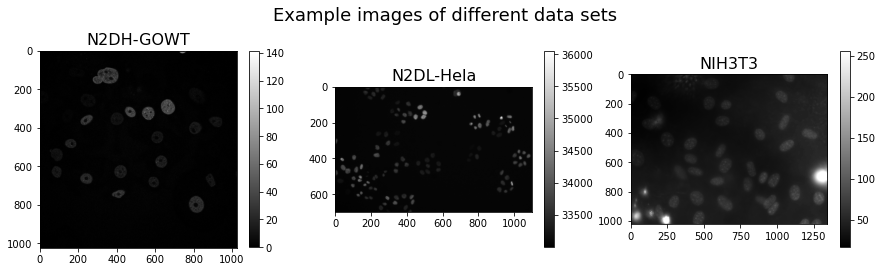

In [2]:
vis.load_images()

# Preprocessing
Preprocessing is an important step in the preparation of images.
Clipping, filtering and other methods can be used to optimize the data to yield better results.
For instance, background noise can be decreased, and the essential content of the image can be elaborated.
However, it is crucial to avoid losing relevant information by overuse of preprocessing.

## Clipping
With the clipping method, all intensity values of an image below or above manually defined thresholds will be set to
these thresholds.
This allows to combine extreme values and to reduce the intensity spectrum. For clipping, a pre-implemented method
from the numpy module is used.

In addition, a separate method was implemented in which the values below or above the thresholds were set to the
minimum and maximum intensities of the image.
This variant is intended to increase the contrast of the combined intensities to the remaining.
Below the original, unprocessed picture, the normal clipped picture and the picture clipped with the self
implemented function are shown:

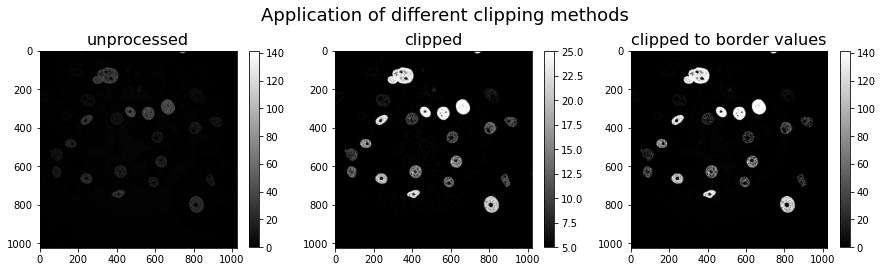

In [3]:
vis.clipping_examples()

In order to reduce disturbances of an image caused by very bright intensity values, the functions remove_bright_spots
and remove_bright_spots_with_border were implemented. The first method sets the intensity values of bright spots to an
intensity similar to the background.
The second method clips the bright spots together with a border around the bright spots of variable size.
This will be very useful for the third data set to fade very bright spots into the background using two different
thresholds. The first threshold defines which intensity is considered as bright, and the second sets these pixels to a
lower intensity, which is similar to the background.

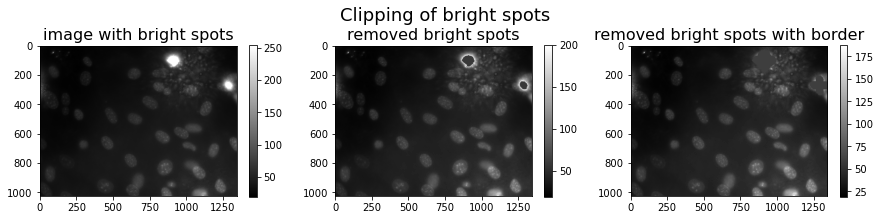

In [4]:
vis.bright_spots_example()

## Filtering
Median and gaussian filtering were considered to improve the segmentation results.

The median filter sorts the intensity values of the specified neighborhood and assigns the median value to the
central pixel.

The Gaussian filter is a linear filter that weights the intensity values of the specified neighborhood with a
Gaussian distribution.
Subsequently, the calculated mean value is assigned to the central pixel.
Due to the weighting, the Gaussian filter is an improvement of the Mean filter.

A pre-implemented function of the numpy module has been used for both filtering methods.

# Segmentation algorithms
## Seeded region growing algorithm
Seeded region growing is a sub-method of image segmentation.
It consists of the determination of initial seeds, followed by the assignment of pixels to the seeds, known as Seeded
region growing (Adam and Bischof, 1994).
Regions can then be combined in region merging.
The implementation of the seeded region algorithm is based on the paper of Frank Y. Shih and Shouxian Cheng
(Shih and Cheng, 2005).

### Seed selection
In order for pixels to be selected as seeds, they must fulfill two conditions.
One concerns the similarity, the other the maximal Euclidean distance of a pixel to its neighborhood.

#### Seed selection based on similarities
To evaluate the similarity, the standard deviation $\sigma$ of each pixel to its 3x3 neighborhood is calculated:

$$ \sigma = \sqrt{\left(\frac{1}{9}\sum\limits_{i=1}^{9}(x_i-\overline{x}\right)^2}$$

with $x_i$ as pixel intensities and $\overline{x}$ as the mean intensities of the 3x3 neighborhood of a pixel.
$\sigma$ is then normalized by dividing by the maximum value of all calculated standard deviations. The
similarity $s$ is obtained from the following equation:

$$s=1-\frac{\sigma}{\sigma_{max}}$$

The similarity $s$ is then compared to a threshold.
If $s$ is greater than the threshold, the pixel can be considered as seed.
For this purpose, Otsu thresholding was used to define the threshold value.

#### Seed Selection based on Euclidean Distance

Now all pixels whose similarity $s$ is greater than a threshold are further used for seed selection based on
Euclidean distance in order to exclude pixels that lie on the border between two regions.
The maximum value $d_{max}$ of the Euclidean distances of a pixel to its neighborhood is calculated by:

$$d_{max} = \mathop{max}_{1\leq i\leq 8} \left\{ d_i = \frac{x-x_i}{x} \right\}$$

$d_{max}$ is then also compared to the threshold.
If $d_{max}$ is lower than the threshold, the pixel is considered a seed.

For visualization the  algorithm is applied to a section of the loaded image.
The implemented algorithm results in the following seeds:

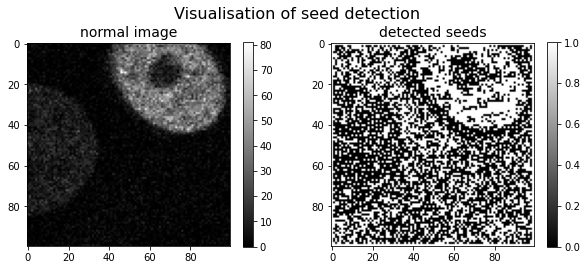

In [5]:
image_intensity_small = sk.imread("Data/N2DH-GOWT1/img/t01.tif")[300:400, 400:500]
image_seeds = sd.seeds(image_intensity_small, 0.5)
ip.show_two_images_title(image_intensity_small, image_seeds, "Visualisation of seed detection", "normal image",
                         "detected seeds", 0.94)

### Seeded region growing
Before starting the region growing algorithm based on the selected seeds, the seeds have to be assigned to regions.
In this process, connected seeds are merged to one region.
This possibly leads to a big amount of regions if many unconnected seeds have been detected.
To reduce the region number, regions smaller than a threshold can be removed using the reduce_region_number function.

In [6]:
image_regions_from_seeds = sd.seed_merging(image_seeds)
image_regions_from_seeds = sd.reduce_region_number(image_regions_from_seeds, 7)

The seeded region growing algorithm labels all pixels to the regions created out of the seeds iteratively.
Thereby, it always labels the pixel with the closest intensity distance to one of its neighboring regions first
(Gómez et al., 2007)(Shih and Cheng, 2005).

The algorithm follows the steps below:
1. First, the neighboring pixels to the created regions are selected and stored in four 2D numpy arrays for left, right,
top and bottom neighbors.
1. The distance of these pixels to its neighboring regions is calculated based on previously computed mean intensity
values of the regions. The formula $dist = \frac{|p - \bar r_n|}{intensity_{max}}$ is used.
1. The smallest distance is selected, and the associated pixel position is determined. This pixel is now merged to its
neighboring region.
1. Before the next pixel can be selected, the mean intensity value of the changed region, the arrays of neighboring
regions, and the distances to the changed region need to be recalculated.
1. Again, the most similar pixel is selected and labeled. This procedure is repeated until all pixels are labeled.

Below the results of seeded region growing are shown (original image left, seeds middle, image after
region growing right).

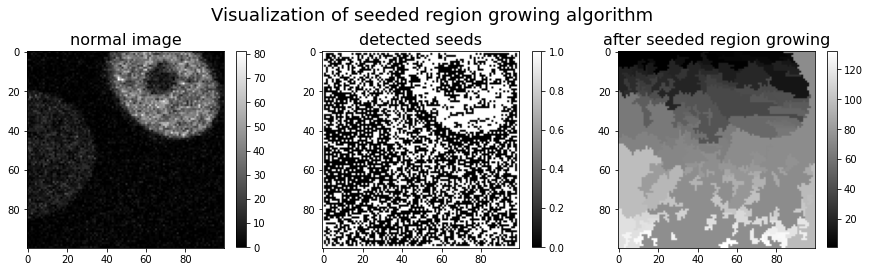

In [7]:
image_regions = srg.region_growing(image_intensity_small, image_regions_from_seeds.copy())
ip.show_three_images_title(image_intensity_small, image_seeds, image_regions,
                           "Visualization of seeded region growing algorithm", "normal image","detected seeds",
                           "after seeded region growing", 0.45, 0.75)

## Unseeded region growing algorithm
Furthermore, another region growing algorithm was implemented based on the paper of Zheng Lin, Jesse Jin and
Hugues Talbot (Lin et al., 2000). In difference to seeded region growing where several pixels are detected before the
algorithm starts, in unseeded region growing only one start pixel is chosen beforehand.

The algorithm is similar to
seeded region growing and follows the steps below:
1. Based on the first seed the neighboring pixels are selected and stored in 2D numpy arrays for left, right top and
bottom neighbors.
1. The intensity distance of these neighboring pixels to the start region is calculated according to $dist = |p - \bar r_n|$
1. The smallest distance and the associated pixel are selected.
1. This pixel is now labeled. For labeling three options exist:
    1. If the intensity distance of the pixel is smaller than a threshold, the pixel is merged to its neighboring
    region. Otherwise it will be proceeded with the next condition.
    1. If the intensity distance of the pixel to another, not neighboring, region is smaller than
    the threshold, the pixel is merged to this region.
    1. If both previous conditions are false, the pixel forms a new region.
1. After labeling the first pixel, the arrays of neighboring pixel need to be updated, and the intensity distances
are recalculated. This is used to calculate the pixel which is labeled next according to the above conditions.
1.  The algorithm continues until all pixel are labeled to a region.

The result of unseeded region growing can be seen below compared to the unprocessed image.
Here the pixel on position (0,0) is selected as the starting point.

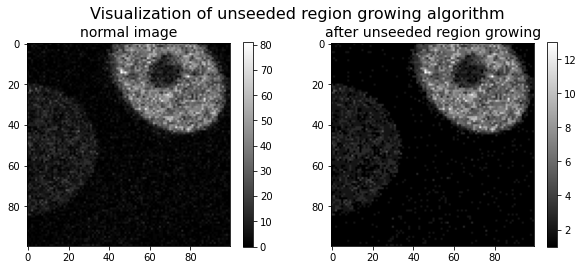

In [8]:
image_result_unseeded = urg.unseeded_region_growing_algorithm(image_intensity_small, (0, 0), 5)
ip.show_two_images_title(image_intensity_small, image_result_unseeded,
        "Visualization of unseeded region growing algorithm", "normal image", "after unseeded region growing",  0.94)

## Region merging
In both algorithms, seeded and unseeded region growing, too many regions are received due to high intensity differences
in the background as well as in the cell nuclei.
To solve this over-segmentation a region merging algorithm was implemented.
The received regions are merged based on two criteria: distance of intensity values and region size.

### Region merging based on distance of intensity
The first selection criteria is implemented via the following procedure:
1. First, the neighboring regions are determined for every region and stored in a 2D numpy array.
1. This is used to calculate the distances between all neighboring regions which are stored in an upper triangle 2D
numpy array. The distance between two regions is calculated using $dist = \frac{\bar r_m - \bar r_n}{intensity_{max}}$
1. Then the most similar regions are selected and merged.
1. This procedure is repeated until the distance between the most similar regions is bigger than a threshold.
For that, in every iteration the mean intensity value of the newly merged region, and the distances to its
neighboring regions are updated as well as the numpy array, in which neighboring regions are stored.

### Region merging based on size
Region merging by size follows the steps below:
1. First, the size of every region is calculated and stored in a 1D array.
1. The smallest region is selected and compared to a threshold. If it is smaller, the algorithm continues.
1. The previously determined neighboring regions are used to find out the most similar neighboring region by
calculating the distances. The selected smallest region is merged to its most similar neighbor.
1. Afterwards, region sizes are updated, the smallest region is recomputed and its size is compared to the threshold.
1. The next most similar neighboring region is determined based on recalculated distances and neighboring regions.

The algorithm stops as soon as the smallest region is bigger than the threshold.

To easily differentiate between nuclei and background, a clipping algorithm is used on the result of the region merging
algorithm. This algorithm clips nuclei to the intensity value 1 and background to the value 0.

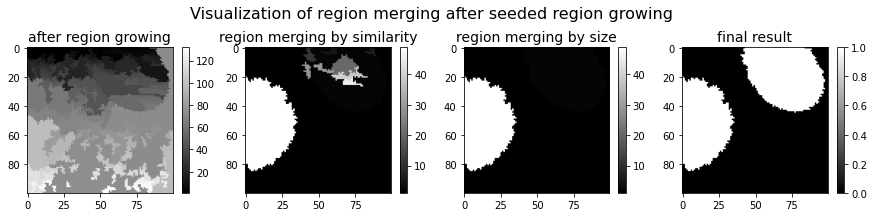

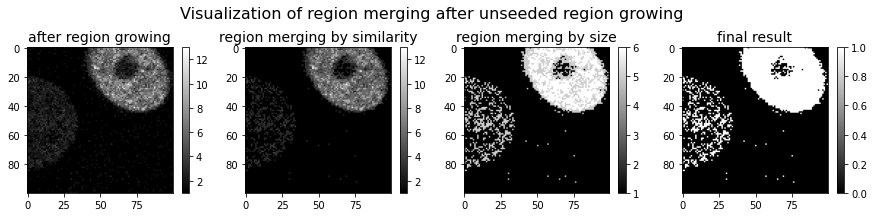

In [9]:
vis.region_growing_example()

Here, the over-segmented image after region growing can be compared with the merged image based on similarity, the image after complete merging based on similarity and size and with the clipped image.
The first row shows the results of seeded region growing and in the second row the results of unseeded region growing can be seen.

## Differences between seeded and unseeded region growing
In seeded region growing the pixels of one region are always connected. In the case of unseeded region growing,
pixels can appear that are assigned to the same region but are not connected.
This leads to differences in the region merging process. Region merging based on intensity distance
leads to good results for seeded region growing.
However, when using region merging based on the distance of intensity for unseeded region growing, pixels of the cell nucleus are easily
merged to the background and build incorrectly assigned pixels within the nuclei. Because of that, a small threshold needs to be chosen for
region merging by distance of intensity.

Instead, region merging by size can be used to merge small regions to their closest neighboring region.
This leads to better results although some unconnected pixels remain.
Opposed to seeded region growing, where one region can only contain one nucleus,
in unseeded region growing a region can consist of several nuclei.
That is why single pixels appear which belong to big, distant regions
and can not be merged because of their small region size.
This results in spots, which resemble salt and pepper noise.
In the image visualising the implementation of the unseeded region growing algorithm (5.ii.) these bright pixels
in the background can be seen.

In order to improve the result, a median filter with a 3x3 sized filter mask was used on the image after region merging.
This improved the Dice score.
When using a bigger filter size, the incorrectly assigned pixels within the nuclei shrink, but nuclei are
only partly detected and thus merged to the background. However, the focus was set on detecting all nuclei, even if
they are only partly detected. As a result, a filter with size 3 was used.

Another difference to be noted is the normalization of the calculated intensity distances.
In seeded region growing, the intensity distances are always normalized to a value between 0 and 1.
Instead, for unseeded region growing, only differences are calculated.
This must be taken into account in preprocessing.
In region merging normalized distances are used, which affects seeded and unseeded region growing.

# Evaluation measures

## Dice score
The Dice score is a method to determine the accuracy of segmentation. Thereby, a ground truth image which is already given
in the data set is compared with the resulting image of the algorithm. The Dice score is defined as follows:
<br>
$$ DSC = \frac{ 2 \times |S \cap G|}{|S| + |G|} $$
<br>
This can be applied to boolean data, where a positive result indicates a detected nucleus,
and a negative result describes the background.
Comparing the segmented image to the ground truth image, a pixel counts as true positive ($TP$) if it is correctly detected as a pixel of a
nucleus. False positive ($FP$) describes pixels falsely labeled as nucleus-pixel,
and false negative ($FN$) terms pixel of overseen nuclei.
Based on this consideration, the Dice score is calculated according to the following formula, resulting in a
value between zero and one. The higher the value of the calculated Dice score the better was the performance of the algorithm.
<br>
$$ DSC = \frac{2 TP}{2TP + FP + FN} $$

# Results
## N2DH-GOWT1
The result of the seeded region growing on the image t01 of the N2DH-GOWT1 data set is shown below. 
For seed detection 0.7 was used as the relative Euclidean intensity distance threshold and smaller seed regions than 2 pixels
were removed. In region merging 0.05 for the relative Euclidean intensity distance threshold and 400 for the size threshold were applied.
A Dice score of 0.865 was obtained.

Comparing the original image with the segmentation result shows that nearly all visible nuclei were caught.
However, in the ground truth image some nuclei are shown, which were not detected by the implemented algorithm.
This difference is reflected in the Dice score, but a value of 0.865 is still satisfying.

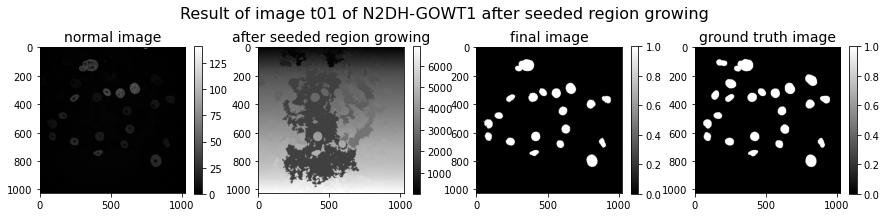

In [10]:
vis.results_gowt1_seeded()

The following images show the results of the unseeded region growing algorithm on the same image (t01).
A Dice score of 0.759 was achieved. The lower Dice score confirms the remaining salt and pepper noise remaining in the merged image
which is also visible in the final image after clipping.
A median filter with sigma 3 has been applied to the image after region merging, which led to an improved merged and filtered image.
The Dice score increases for the final image after merging and filtering after clipping to 0.868 which is similar to the result of seeded region growing.
The unseeded region growing algorithm missed similar nuclei. These nuclei have a very low contrast in intensity to the background and are
therefore harder to detect.

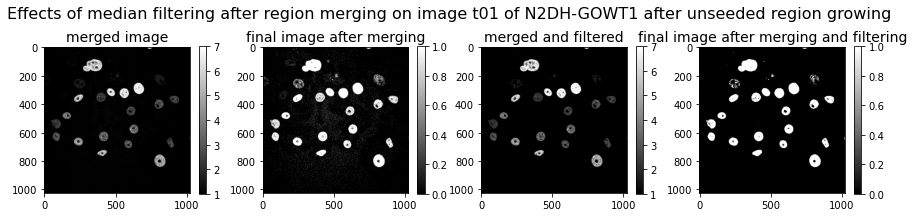

In [11]:
vis.results_gowt1_unseeded()

## N2DL-HeLa
### Shifted intensity range in N2DL-HeLa
The Otsu threshold in seed detection of seeded region growing is used to determine the similarity threshold, above which
pixels are selected as seeds.
Since normalized intensity distances are used, it is necessary to normalize the Otsu threshold as well.
This works well in images with an intensity range starting from 0.
In the N2DL-Hela data set though a very high Otsu threshold was obtained due to the normalization on an intensity range
between 33000 and 36000. This led to memory errors because of too many seeds. It resulted in worse algorithm outcomes
after seeded region growing and region merging because of decreased normalized intensity distances.
Subtracting the minimal image intensity and thereby shifting the intensity range solves this issue.

In unseeded region growing this issue does not occur because intensity distances are not normalized. However, for region
merging based on intensity distance the distances are normalized. As the image was not normalized beforehand, a very small
threshold for intensity merging has to be chosen in order to compensate this.

### High cell density and intensity differences of nuclei
The threshold for region merging by size, under which the region is merged,
needs to be adapted due to the high cell density in this data set.
While for the N2DH-GOWT1 regions smaller than 400 pixel are merged, for N2DL-Hela images the parameter 100. This is used to prevent
losing nuclei that are smaller compared to the nuclei of N2DH-GOWT1.

In addition, the nuclei differ greatly in intensity.
This must be taken into account when merging regions based on intensity distances. The threshold has to be adjusted to the
darkest nuclei to avoid losing them.

### Final results

Seeded Dice score: 0.767329220009245
Unseeded Dice score: 0.8613875306578351


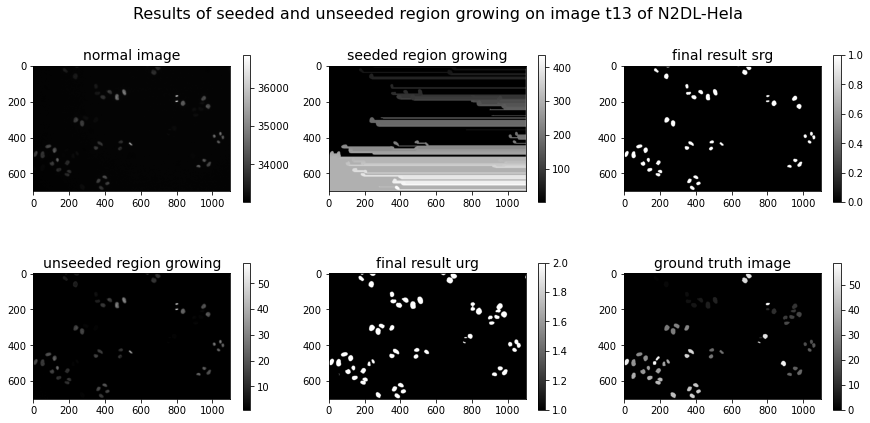

In [12]:
vis.results_hela()

Seeded and unseeded region growing were performed on the image t13 of the N2DL-Hela Data set.
To improve the results of seeded region growing, the normal image was preprocessed.
The intensity range was shifted to have 0 as the lowest intensity (ip.subtract_minimum with t13 as the associated image).
Moreover, the image was clipped (with 0.05 * max(t13) as the lower and 0.15 * max(t13) as the higher clipping threshold).
Lastly, a median filter with sigma 3 was applied.

For seeded region growing, 0.05 was used for the relative Euclidean intensity distance threshold for seed
detection (sd.seeds).
Seed regions smaller than 20 were removed (sd.reduce_region_number).
Region merging was performed with 0.1 as the relative Euclidean intensity distance threshold and 100 as the size
threshold.

No preprocessing was performed for the unseeded region growing, as good results could be obtained without it.
For computing the unseeded region growing algorithm, (0,0) was selected as the start pixel and 50 as the distance
threshold.
In the fifth picture the result after merging with 0.000001 (relative Euclidean intensity distance),
10000 (size threshold), filtering with a median filter (sigma 3)
to remove salt and pepper noise and clipping is shown.

Comparison of the result images with the ground truth image shows that in unseeded region growing most nuclei
were detected while more nuclei were not detected after seeded region growing.
This is also confirmed by the Dice scores of the results.
In general, the first data set leads to better Dice scores for seed region growing.

One reason why more nuclei are lost in seeded region growing compared to the first data set is the higher cell density
and lower intensity distances between background and nuclei. Not every nucleus contained seeds after the seed detection.

## NIH3T3
### Bright spots in NIH3T3 data set
The images of the third data set contain bright spots due to reflections of the microscope which raises the risk of detecting the reflections as nuclei.
Preprocessing can be used to merge the bright spots into the background where removal of bright spots and removal of bright spots with a border are evaluated and compared in the following.

For the normal bright spot removal, all pixels with intensities above a threshold are considered as bright spots. The pixels intensity are then
set to a lower intensity, resembling the background.
Removal with a border creates an artificial border around the pixels that are considered as too bright which is also set to a lower intensity value.
The removal of the bright spots with a border reduces the transition region between the bright spot and the background.
This transition region cannot be removed in any other way because of its similar intensity to the nuclei. This prevents merging.

Nevertheless, the risk of merging nuclei to the background is higher, when a border is removed along with the bright
spots. If the intensity brightness threshold is too low, parts of nuclei will be clipped as well. These small
clipped parts inside the nuclei are not a problem if the bright spot is removed without a border. The clipped regions
within nuclei are small and will be merged to the rest of it. <br>
Removing the border as well led to bigger missing nuclei parts and might make it impossible to compensate the missing
parts in region merging.
Because of that it is important to choose a brightness threshold which keeps the nuclei completely intact,
after bright spots and borders are excised.

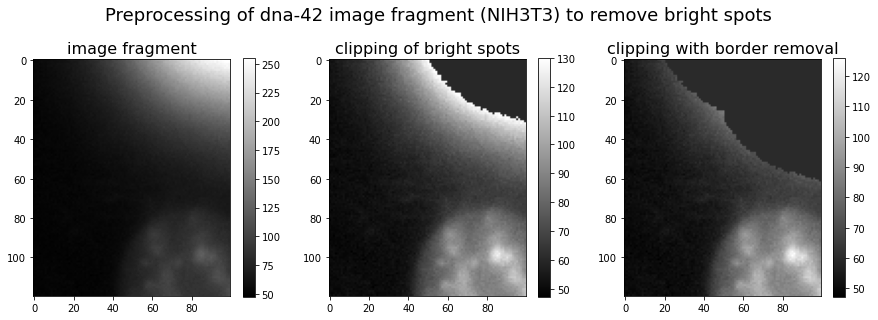

In [13]:
vis.nih3t3_show_bright_spots()

The images are segmented with seeded region growing and clipped afterwards to differentiate nuclei and background.

Dice score with bright spots: 0.5822922324823465
Dice score after removing bright spots: 0.0
Dice score after removing bright spots and border: 0.7735191637630662


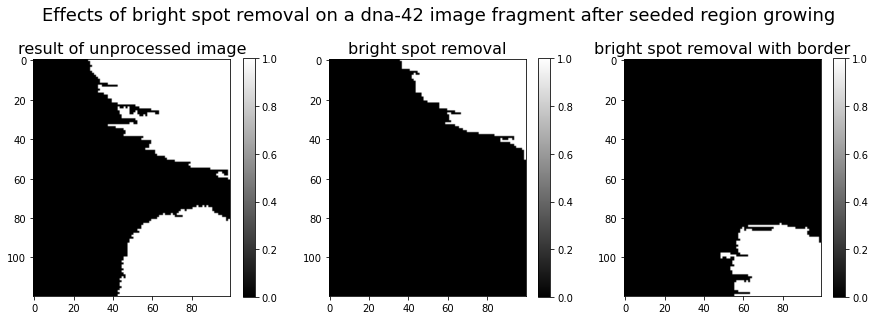

In [14]:
vis.nih3t3_srg_bright_spots()

In the unprocessed image both bright spot and nuclei are detected as nuclei.
This confirms that a removal of the bright image spots is necessary.
In the image with intact nucleus only the reflection is detected and not enough of the bright spot was removed.
The intensity distance merging threshold
rather merges the nucleus to the background than the reflection.
Removing a border along with the bright parts of the reflection solves this problem.
As nearly the whole bright spot is removed, it can be merged to the background by intensity distance.

The Dice scores confirm that the third image was segmented the best but parts of the nucleus has been merged to the background.
This happens because the reflection leads to a smaller intensity difference between background and nucleus.

### Blurs in NIH3T3 data set
A further challenge was that some images in the third data set contained blurs that were smaller than the nuclei but had similar intensities.
They are registered as a region with a relatively close mean to a region of nuclei.
Therefore, they are merged to nuclei even with a low intensity merging threshold.
With merging by size, the blurs are merged to the nuclei. This
happens because their intensities are more similar to the nuclei than the background.

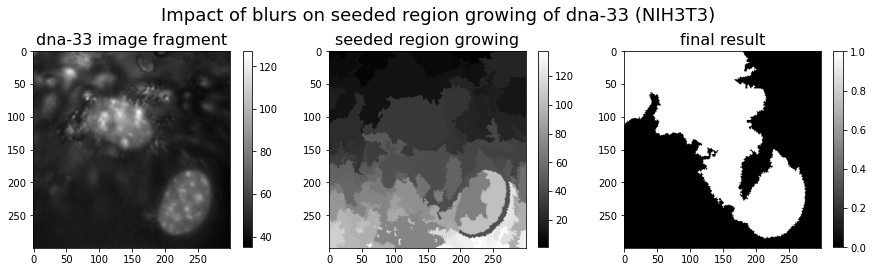

In [15]:
vis.nih3t3_blurs()

### Changing background intensities
In some images of the third data set the background intensities are changing within one image.
This is a problem while merging the background to one region after segmentation which is necessary to differentiate
between nuclei and background.
The nuclei in the darker part of the image have similar intensities to the background in the lighter part making
merging very difficult.
This has less impact on unseeded region growing because there regions are not limited to one nucleus.

### Final results
Below the image dna-42 of the NIH3T3 data set is shown.
For seeded region growing bright spots with border were removed (thresholds: 130 (brightness), 60 (background),
30 (border)) and a 3x3 gaussian filter with sigma 1 was used.
For the seed detection 0.001 (relative Euclidean intensity distance threshold) was used.
Seed regions that are smaller than 5 are deleted.
In the second row, it can be seen that merging led to problems.
The first image shows the result of clipping after merging with the parameters 0.057 (relative Euclidean intensity
distance threshold)and 200 (size threshold).
This led to a Dice score of 0.44 because many cells in the upper fraction of the image were lost.
In the middle, the clipped image is seen after merging with parameters 0.056 (relative Euclidean intensity distance
threshold) and 200 (size threshold).
The Dice score decreased to 0.29 because the background is identified as two regions.
The intensity difference between the two regions in the background is similar to the difference between nuclei
and the background on the left side. Therefore, merging the background was not possible without losing nuclei.
To solve this, manuel merging of the two background regions was conducted. By that, slightly better results were obtained
with a Dice score of 0.50, meaning that still many cells remain undetected.

Because the intensity of the background differs much among the picture, setting the bright spots to an
intensity similar to their neighboring background was not possible. The bright spots were consequently set to an intensity of the background on
the right. This led to problems in region merging, as the spots could not be merged to the background without
losing too many nuclei.
Although the bright spot could be successfully removed in an image fragment,
the algorithm failed on the whole image.

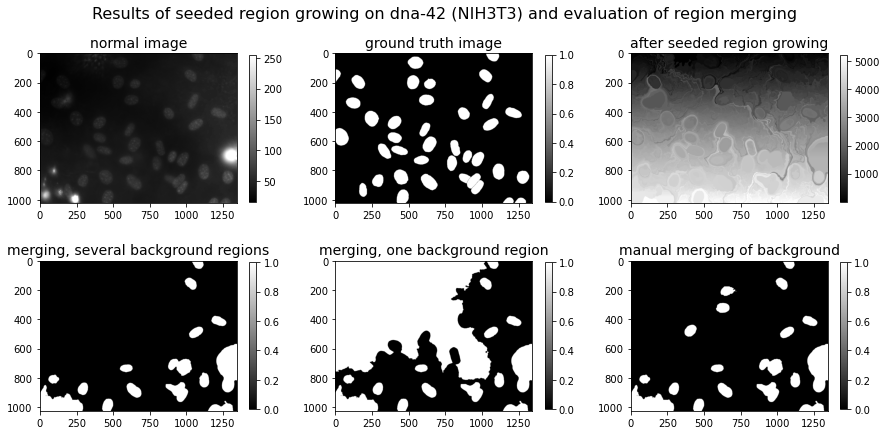

In [16]:
vis.results_nih3t3_seeded()

For the unseeded region growing the following result was obtained.
The first image shows the result after unseeded region growing with the parameters 0.07 (relative Euclidean intensity
distance threshold) and 10000 (size threshold).
Again after merging, a median filter with sigma 3 was used.
The Dice score is 0.55, which shows that repeatedly not all nuclei could be detected, and the bright spots
could not be removed. The reasons are the same as mentioned for seeded region growing.

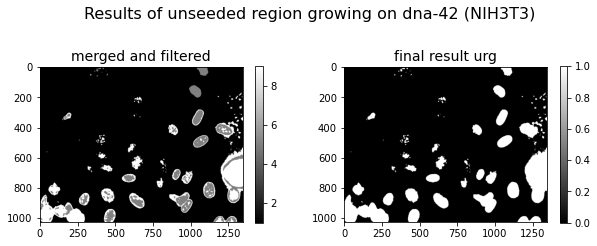

In [11]:
vis.results_nih3t3_unseeded()

Trying out different parameters on the whole image could lead to better results in seeded and unseeded region growing.
However, the long runtimes of 24 hours for one image did not allow that.

Running the algorithm on less challenging images of the data set (dna01) led to better results and a Dice score of
0.86 for seeded and 0.95 for unseeded region growing was obtained. These are the highest Dice scores that were contained.
Numerous and big nuclei led to the increased Dice scores.

## Evaluation of preprocessing
To test, which preprocessing method did lead to the best result, different clipping methods and filters were applied to a small section of an image of the second data set.
The results after applying the different preprocessing methods to the image section can be seen in the first row.
The highest obtained Dice score was used to manually define different parameters for each method.


Dice score of normal image: Seeded region growing: 0.7861184458694832 Unseeded region growing:0.906734291349676
Dice score of clipped image: Seeded region growing: 0.971689497716895 Unseeded region growing:0.972636815920398
Dice score of extremely clipped image: Seeded region growing: 0.9652976758993951 Unseeded region growing:0.9652976758993951
Dice score of median filtered image: Seeded region growing: 0.7847432024169184 Unseeded region growing:0.972972972972973
Dice score of gaussian filtered image: Seeded region growing: 0.7556071152358855 Unseeded region growing:0.9354945418458485


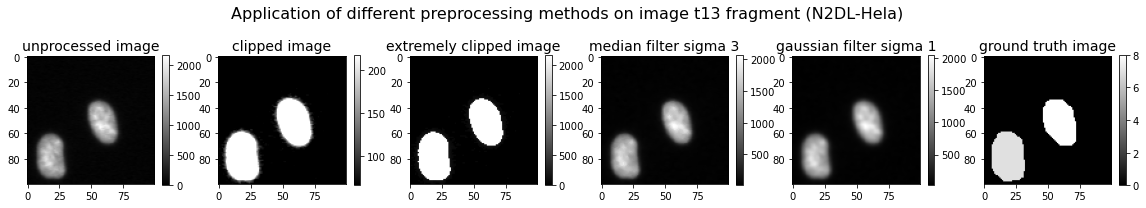

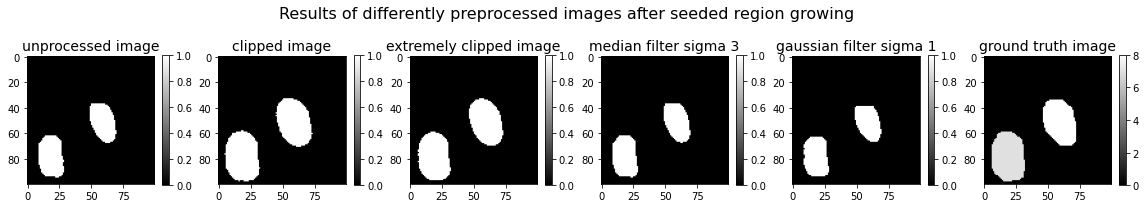

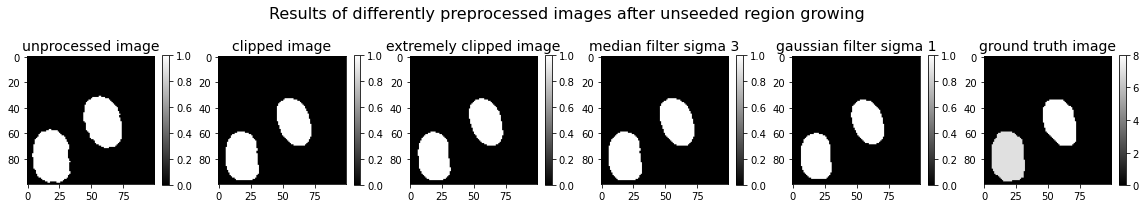

In [18]:
vis.show_preprocessing()

The results of the different preprocessed images after applying the algorithm for seeded and unseeded region growing are shown in the second and third row.
For each image, the Dice scores were calculated and are shown in this bar plot.

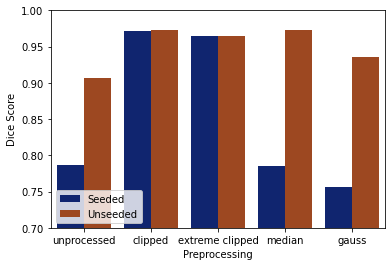

In [19]:
vis.barplot_preprocessing()

Looking at the Dice score it can be seen that preprocessing has basically improved the results and the algorithm for seeded and unseeded region growing is working quite well.

Regarding the seeded region growing algorithm, for all preprocessing methods the Dice score remained approximately the same or was improved, except for appliying the gaussian filter.
This might be caused by the fact that the Gaussian filter with sigma 1 does not change the intensities significantly, but a larger sigma results in blurring and a lower Dice score.
Both clipping methods led to significantly improved Dice score, while the normal clipping performs best with a Dice score of 0.972.
The reason for the high Dice score is that clipping removes background noise without blurring the image.
Furthermore, the darker pixels at the border of the nuclei are better detected, Because the intensity distance to the background increases.

By applying unseeded region growing to the preprocessed image section all Dice scores could be improved.
Again, the Gaussian filter performs worst compared to the other methods.
The highest Dice scores were obtained using the median filter, followed by the normal clipping method which both do not mainly differ in their obtained Dice score.
Compared to seeded region growing, the unseeded region growing algorithm showed better results and therby yielded to higher dice scores for both unprocessed and preprocessed images.

## Comparison seeded and unseeded region growing results
For both, seeded and unseeded region growing, parameters need to be determined for every image and data set
individually.
However, after optimizing preprocessing methods and parameters unseeded region growing lead to better results,
especially in challenging data sets. This can be seen in the bar chart below.


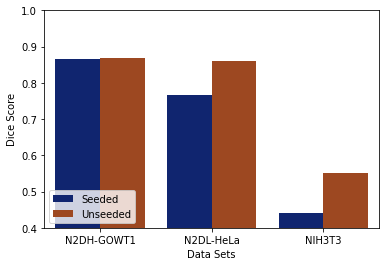

In [20]:
vis.barplot_results()

# Challenges
## Runtime errors
### Optimizing seeded region growing algorithm
The implementation of Frank Y. Shih and Shouxian Cheng (Shih and Cheng, 2005),
on which the implemented seeded region growing algorithm is based, labels every pixel individually, which leads to long runtimes.
This is why many runtime problems were encountered, especially with the first implemented seeded region growing
algorithm.

In this first region growing algorithm, all pixels neighboring an existing region are stored in a list. For-loops are used
to iterate over this list to find the pixel with the smallest intensity distance to a neighboring region. With this
algorithm it is impossible to segment a whole image in a reasonable time using the available hardware.

Hence, a new algorithm was implemented. It was evaluated whether to use numpy arrays or pandas data frames to
vectorize the algorithm. It was decided to use numpy arrays because of their faster runtimes.
Before, only the smallest distance of a pixel to its neighboring regions could be stored and so the distances had to
be recalculated during each loop. Now, all distances were stored.
Moreover, the use of for-loops was almost completely avoided, and the algorithm was vectorized.
On a fraction of the image, the runtime could be 10-fold decreased. Using a whole image, the improvement would be
even bigger. This allows to execute the region growing algorithm using a whole image in 24 hours.

In [21]:
image_intensity_small = sk.imread("Data/N2DH-GOWT1/img/t01.tif")[300:350, 400:450]
image_seeds = sd.seeds(image_intensity_small, 0.01)
image_regions_from_seeds = sd.seed_merging(image_seeds)
%timeit srg.region_growing(image_intensity_small, image_regions_from_seeds.copy())
%timeit old_srg.region_growing(image_intensity_small, image_regions_from_seeds.copy())

665 ms ± 12.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.97 s ± 62.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Optimizing unseeded region growing algorithm
The algorithm proposed unseeded region growing algorithm in the paper of Zheng Lin, Jesse Jin and Hugues Talbot (Lin et al., 2000)
led to the same problem. Because every pixel is
assigned individually, the runtime of the first implemented algorithm is too long to segment a complete image with the
available hardware.

This is why the algorithm was rewritten similarly to the seeded region growing algorithm.
The runtime decreased by nearly 30 times.

In [22]:
%timeit urg.unseeded_region_growing_algorithm(image_intensity_small, (0,0), 5)
%timeit old_urg.old_unseeded_region_growing_algorithm(image_intensity_small, (0,0), 5)

882 ms ± 12.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
30.6 s ± 10 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Comparison of seeded and unseeded region growing algorithm
Whilst comparing both algorithms, no significant runtime difference between both algorithms can be discovered when
compared on a small image. The runtime difference lies within the $3 \sigma$ interval.

In [23]:
%timeit srg.region_growing(image_intensity_small, image_regions_from_seeds.copy())
%timeit urg.unseeded_region_growing_algorithm(image_intensity_small, (0, 0), 5)

877 ms ± 214 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
991 ms ± 158 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Memory error
For the region merging algorithm an array with the same number of rows and columns as the region number
is needed. If too many seeds are found in the seed detection, too many regions are detected in the seeded region
growing, and the region merging algorithm can not be performed. When trying to do so, a memory error occurs.
This is why a method to reduce the seed number was implemented.
In unseeded region growing fewer regions occur which solves this problem right away.

# Discussion
Despite the challenges of the different data sets images of each data set could be segmented successfully
using preprocessing. Especially in the first data set N2DH-GOWT1 satisfying results and high Dice scores were obtained.
In the second data set (N2DL-Hela) normalizing and preprocessing could be used to gain high Dice scores.
Little challenging images of the NIH3T3 data set led to high Dice scores as well.
However, especially in images with bright spots and differing image intensities lower Dice scores where obtained.
Even though these challenges could be solved on image fragments, the resources didn't suffice to solve these issues
on the whole image because of too long runtimes. This needs to be addressed in future research.

Preprocessing, especially clipping, of the images improved the results and is therefore recommended.
For filtering a median filter showed to improve results on images for unseeded region
growing and image clipping improved the results of seeded region growing. On difficult
data sets, a Gauss filter was additionally used to improve seed detection.

Although both, seeded and unseeded region growing, lead to good results,
unseeded region growing was more robust against challenging image parts.
One reason is that the seed detection in seeded region growing often fails to detect nuclei
or background regions between nuclei.
Increasing the number of seeds could solve this problem, but it leads to memory errors.
Alongside less memory errors and smaller execution times for region merging, the smaller region number in unseeded
region growing leads to bigger, unconnected regions with several nuclei. This compensates small intensity distances
of nuclei to their background in bright background areas or because of dark nuclei.
However, challenge of unseeded region growing are additional filtering methods which need to be applied after
region merging.
Since both algorithms still showed good results and Dice scores, they can be considered in future research.

For evaluation only the Dice score was used.
To gain a meaningful Dice score all background regions need to be merged together.
This requirement complicates segmentation on images which differing background intensities and leads to worse results.
Differences of ground truth images and the received results are partly caused by mistakes in the ground truth images,
which do not show nuclei on image borders.
Because of these problems, other evaluation methods should be considered in future research.

Despite the big runtime improvements, the runtime in both proposed algorithms is still too long. An algorithm which
labels more than one pixel in one iteration could fix this problem. This is why using another algorithm
is recommended in following research.

All in all, both segmentation algorithms lead to satisfying results.
Nevertheless, in future research the process of determining parameters needs to be automated to gain actual time
reduction in nuclei detection via image segmentation.

# Bibliography
1. Adams, R., Bischof, L. (1994). Seeded region growing. IEEE Transaction on Pattern Analysis and Machine Intelligence 16, 641-647
1. Lin, Z., Jin, J., and Talbot, H. (2000). Unseeded region growing for 3D image segmentation. In Selected papers from
the Pan-Sydney workshop on Visualisation - Volume 2 (Sydney, Australia: Australian Computer Society, Inc.), pp. 31–37.
1. Shih, F.Y., and Cheng, S. (2005). Automatic seeded region growing for color image segmentation. Image and Vision
Computing 23, 877-886.
1. Gómez, O., Gonzalez, J., and Morales, E. (2007). Image Segmentation Using Automatic Seeded Region Growing and
Instance-Based Learning, Vol 4756.





